In [ ]:
#download 100patients.zip from google drive
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Download actual file
file_patients = drive.CreateFile({'id': '1411dbH9v-1M92CulcOGVTzQ1pKN-CwfG'})
file_patients.GetContentFile('100-patients.zip')


In [ ]:
!unzip 100-patients.zip

Archive:  100-patients.zip
  inflating: AdmissionsDiagnosesCorePopulatedTable.txt  
  inflating: AdmissionsCorePopulatedTable.txt  
  inflating: LabsCorePopulatedTable.txt  
  inflating: PatientCorePopulatedTable.txt  
  inflating: ReadMe.txt              


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

#Take the PrimaryDiagnosisDescription column as raw clinical note tet
df_admdiag = pd.read_table('AdmissionsDiagnosesCorePopulatedTable.txt')

#show a few records of raw text
print(df_admdiag['PrimaryDiagnosisDescription'][0:10])

#vectorize the text into keyword vectors
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df_admdiag['PrimaryDiagnosisDescription'])

#cluster using Euclidean distance
#(not as good as cosine distance for text but it works for this dataset)
true_k = 10 # just picking 5 clusters randomly
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)
clust_labels = model.predict(X)

order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

#show some of the terms associated with cluster centroids
for i in range(true_k):
  print("Cluster %d:" % i),
  for ind in order_centroids[i, :5]:
    print(' %s' % terms[ind])

0    Direct infection of joint in infectious and pa...
1    Disseminated intravascular coagulation [defibr...
2           Chronic myeloid leukemia, BCR/ABL-positive
3    Rheumatoid polyneuropathy with rheumatoid arth...
4    Acute lymphoblastic leukemia not having achiev...
5    Nerve root and plexus compressions in diseases...
6    Thoracic, thoracolumbar, and lumbosacral inter...
7    Renal failure following (induced) termination ...
8                        Malignant neoplasm of trachea
9    Rheumatoid myopathy with rheumatoid arthritis ...
Name: PrimaryDiagnosisDescription, dtype: object
Cluster 0:
 diseases
 classified
 infectious
 parasitic
 osteonecrosis
Cluster 1:
 complicating
 pregnancy
 puerperium
 trimester
 diseases
Cluster 2:
 renal
 impairment
 gout
 kidney
 left
Cluster 3:
 rheumatoid
 arthritis
 factor
 coronary
 vasculitis
Cluster 4:
 diabetes
 mellitus
 diabetic
 type
 retinopathy
Cluster 5:
 disorders
 classified
 related
 puberty
 opioid
Cluster 6:
 disease
 left
 

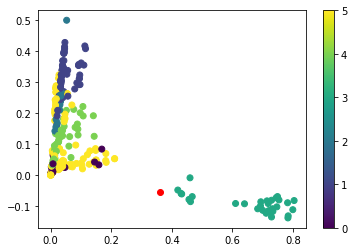

query sentence belongs to cluster 0


In [ ]:
# tfidf vectors have many dimensions, to visualize we must reduce to two dimensions
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

pca = TruncatedSVD(n_components=2).fit(X)
data2D = pca.transform(X)
plt.scatter(data2D[:,0], data2D[:,1], c=clust_labels,cmap='viridis')
plt.colorbar()  # show color scale

query = vectorizer.transform(['Mood disorder due to known acute rheumatoid arthritis'])
predicted = model.predict(query)

query2D = pca.transform(query)
plt.scatter(query2D[0,0], query2D[0,1], c='red', label=predicted)

plt.show() 
print('query sentence belongs to cluster %d' % predicted[0])

Creating queries that are unique (they cannot share words between them) and result in the same cluster for both of them (but a different cluster than the original 'Mood disorder due to known acute rheumatoid arthritis' query)

For example, if the original 'Mood disorder due to known acute rheumatoid arthritis' query resulted in cluster 4 then our two new queries should result both in cluster 0, 1, 2, or 3.

In [ ]:
def predict_query(query):
  query = vectorizer.transform([query])
  predicted = model.predict(query)
  print('query sentence belongs to cluster %d' % predicted[0])
  
query2 = 'Morning sickness is common in first trimester'
query3 = 'glucose level soars up during pregnancy '
predict_query(query2)


query sentence belongs to cluster 1


In [ ]:
predict_query(query3)

query sentence belongs to cluster 1


#Increasing the value of true_k (number of clusters) until our two queries end up in different clusters

In [ ]:
true_k = 6
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)
clust_labels = model.predict(X)

order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

predict_query(query2)
predict_query(query3)

query sentence belongs to cluster 5
query sentence belongs to cluster 2
